# Softwareaufgabe Systemidentifikation
```shell
Seminar: Adaptive Filter, SoSe 2018
Betreuung: M.Sc. Liven Lange, Prof. Dr.-Ing. Sikora

Eingereicht von Maximilian Weber (385153)
```
<img src="media/SimAufgabe.png" alt="Drawing" style="width: 800px;"/>

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tools as ts

# import data as dictionary
importMat, fileNames = ts.importmat('./data/')

*** Toolbox succesfully loaded.
*** Importing files from directory: ./data/
* importing: System_FIR27.mat
* importing: System_FIR3.mat
* importing: System_IIR27.mat
* importing: Systemwechsel_FIR27.mat
* importing: Systemwechsel_IIR27.mat
* importing: Test.mat
* importing: Training.mat
*** 7 files imported


## Vorbereitungsaufgabe
Erstelle ein empfängerseitiges adaptives FIR Filter mit $N$ Koeffizienten, dass anhand des empfangenen Signals $d[k]$ eine Systemidentifikation durchführt. Implementiere eigenständig sowohl den LMS als auch den RLS als Lernalgorithmus.

<img src="media/SimSetup.png" alt="Drawing" style="width: 800px;"/>

In [2]:
# import algorithms (see algorithms.py)
import algorithms as algo

*** Algorithms succesfully loaded.


## Aufgabe 1: FIR Systemidentifikation via LMS Algorithmus
Für das FIR-Filter: Untersuche den Einfluss der Anzahl an Filterkoeffizienten $N \in \{1, 2, 5\}$, der Wahl des Lernalgorithmus (LMS, RLS) sowie den Einfluss der Varianz des AWGNS ($\sigma^2 \in \{0.001, 0.1, 1, 10\}$). Wähle sinnvolle Kombinationen um die Einflüsse gut beschreiben zu können. Dokumentiere dazu die Filtergewichte und Fehlerwerte je Iteration. Vergleiche LMS und RLS miteinander und beschreibe jeweilige Vorzüge und Nachtteile.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


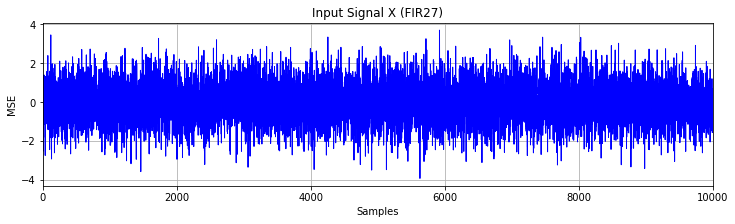

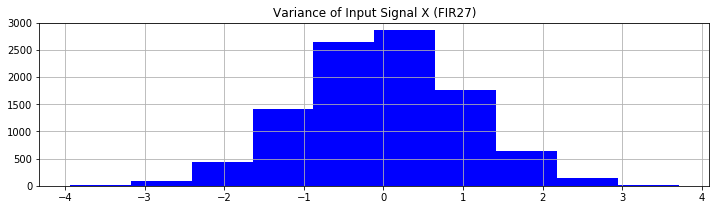

In [3]:
# load FIR data from dictionary
HfirD = importMat['System_FIR27']['D_']
HfirX = importMat['System_FIR27']['X']

# check input signal variance and plot
ts.plot(HfirX,'Input Signal X (FIR27)','lin',10000)
ts.hist(HfirX,'Variance of Input Signal X (FIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))
#print('Eigenvalue Spread of X:', ts.eigSpread(HfirX,1000))

#### Aufgabe 1: Systemidentifikation eines FIR Systems mit variablem AWGNS


Zunächst werden wie in _Aufgabe 1_ verlangt alle Filtergewichte und Fehlerwerte je Iteration von der LMS Funktion gespeichter und somit dokumentiert. Der mittlere quadratische Fehler (engl. Mean-Squared Error bzw. MSE) wird hierbei im oberen Subplot als Lernkurve pro Iteration in Samples aufgetragen. 
Ein gegen 0 konvergierender Verlauf ist hier optimal, denn so zeigt sich das der Fehler zwischen dem gewünschten Signal und dem Ausgang des Filters geringer wird und das sich somit auch das Filterverhalten durch den Algorithmus verbessert.

Der untere Subplot visualisizert die jeweiligen Filtergewichte für jede Iteration. Eine Konvergenz zu einem fixen Wert für jeden Filtertap ist hier erwünscht und zeigt das das sich der Filter zunehmend auf ein Optimum zubewegt.


**Die Anzahl der Filtertaps $N$** is maßgeblich für die Komplexität des adaptiven Filters und bezeichnet die Anzahl der zur Verfügung stehenden Filterkoeffizienten des FIR-Filters. Laut Vorlesung muss diese selbst bei komplexen oder chaotischen System nich sonderlich hoch gewählt werden. Selbst eine Anzahl von etwa 10 Koeffizienten zeigt ähnlich gute Ergebnisse wie etwa 100 bei der Adaption eines chaotischen Systems wie bspw. der *Mackey-Glass time-series* [2, p.55].


**Die Schrittweite $\mu$** beeinflusst wie stark der Fehler $e[n] = d[n] - y[n]$ die Adaption für jede Iteration gewichtet. Ein großes $\mu$ erhöht dabei die Geschwindigkeit der Adaption, kann aber auch zu sehr "nervösem" Verhalten der Adaption führen und eine Konvergenz ins Fehlerminimum durch ständiges Über- und Unterschreiten der Optimalgewichtung bzw. dem zu erreichenden Minimalfehlers $J_{min}$  unmöglich machen. Eine klein gewählte Schrittweite vermeidet starkes Über - und Unterschreiten des Optimums. Die Adaption dauert aber entsprechend länger um sich in die Nähe des zu erreichenden Optimums zu bewegen.


**Die Rauschvarianz $\sigma^2$** beeinflusst die Standardabweichung des AWGNS (Additive White Gaussian Noise), welches dem in der Simulation übertragenen Signal $d[k]$ durch die Messstrecke aufaddiert wird. Die Varianz beeinflusst hiermit die "Stärke" des Rauschens indem durch große Werte auch große, zufällige Amplitudenwerte möglich sind. Kleine Werte für $\sigma^2$ halten also das Signal-Rausch-Verhältnis groß (SNR groß) und große Werte für $\sigma^2$ erwirken ein geringeres Signal-Rausch-Verhältnis. Große Werte "verrauschen" das Zielsignal also stärker, was in unserer Simulation einer schlechteren Übertragunggstrecke entsprechen würde.
Mit dem hinzufügen des AWGNS können wir die Stabilität des Filters gegenüber Rauschen prüfen und somit ermitteln welche Algorithmen sich für ein solches Problem Übertragungsproblem eignen und wie schlecht die Verbindung dabei werden darf um trotzdem zufriedenstellende Ergebnisse zu erhalten.


**Die Lernkurve** trägt den mittleren quadratischen Fehler zwischen dem Zielwert $d[n]$ und dem Ausgang des Filters $y[n]$ für jeder Iteration $n$ in Samples auf, also: $(e[n])^2 = (d[n] - y[n])^2 = MSE[n]$. Wird der Fehler über Zeit bzw. für jedes fortlaufende Sample kleiner so lässt sich das als Verbesserung der Adaption des Filters interpretieren. Der MSE kann auch in Dezibel der Form $MSEdB = 10 \cdot log10(\frac{e_n}{e_0})$ aufgetragen werden. Die Einheit *Bel* dient immer zur Kennzeichnung des dekadischen Logarithmus des Verhältnisses zweier gleichartiger Energie- bzw. Leistungsgrößen. In meiner hier vorliegenden Implementierung (`ts.errorPlot`) wird analog zu Moschytz [1, p.153/154] die Bezügsgröße $e_0$ als der erste vorliegende Fehler $e[0]$ gewählt. Somit bezieht sich die Verbesserung in Dezibel im Verhältnis immer auf den ersten gemessenen Fehler des aktuellen Durchlaufs. Eine Angabe von bspw. $-13\,dB$ bezieht sich also nicht auf die Verbesserung des SNR im Signal sondern jediglich auf die Verbesserung gegenüber dem Anfangsfehlers.

* LMS: N = 1, mu = 0.01, w = [0.70636752]
       with AWGNS variance = 0.001, SNR = 27.91 dB


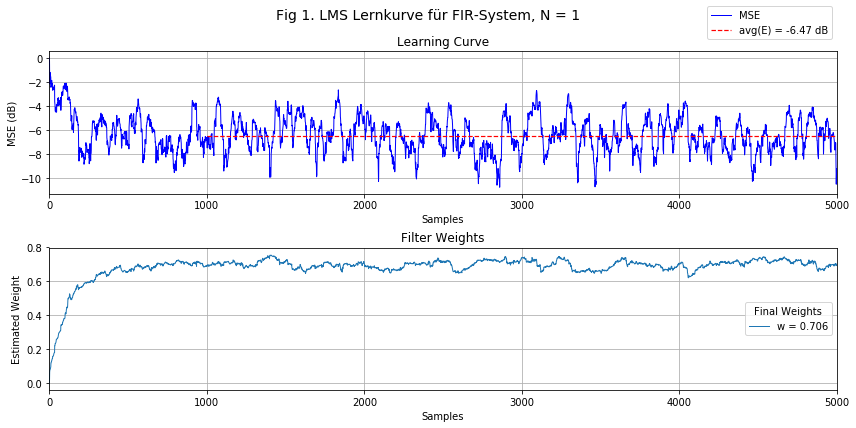

In [6]:
# FIR LMS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 5000

# N = 1
N, mu, var = 1, 0.01, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 1. LMS Lernkurve für FIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 1.** Um die Komplexität des (unbekannten) FIR-Systems aus der Aufgabe mit $N = 5$ zu erreichen sind, wie im ersten Plot oben zu sehen $N = 1$ Taps nicht hinreichend. Obwohl hier eine nahezu optimale Übertragungsstrecke mit kaum Rauschen vorliegt ($\sigma_1^2 = 0.001$) und die Schrittweite sehr gering gewählt wurde wird das Rauschen bei einem Signal-Rausch reellen Verhältnis von $27.8 \,dB$ im Verhältnis zum Anfangsfehler durschnittlich um etwa $-6.5 \,dB$ reduziert. 
Eine Rauschtoleranz müsste beim Entwurf des Filtersystems vorher definiert werden um eine Eignung des zu prüfenden Systems zu definieren. Ansonsten verbleibt nur eine qualitative Auswertung dieses Werts.

* LMS: N = 2, mu = 0.01, w = [0.70936791 0.08322238]
       with AWGNS variance = 0.01, SNR = 17.81 dB


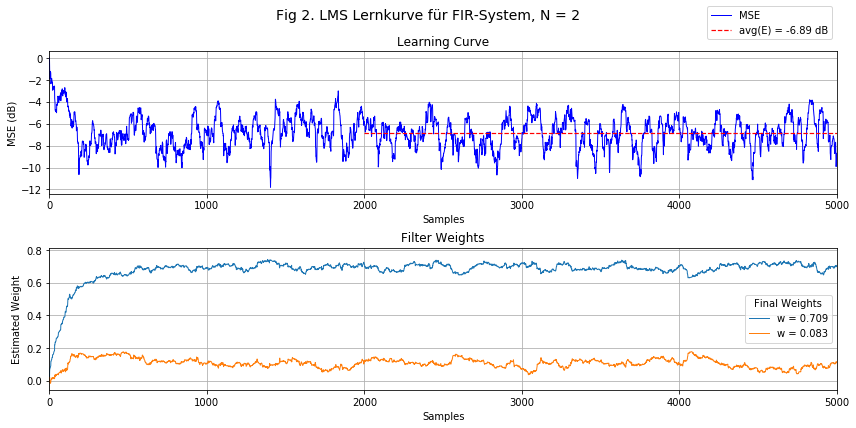

In [7]:
# N = 2
N, mu, var = 2, 0.01, 0.01
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 2. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 2.** Eine ähnlich gute Rauschunterdrückung zu *Fig 1* bei $N = 1$ mit etwa $-6.5 \,dB$ im Verhältnis zum ersten Fehlerwert erfolgt trotz der zehnfachen Varianz ($\sigma_2^2 = 0.01 = 10 \cdot \sigma_1^2$) des beigemischten Rauschens bei bloßer Verdopplung der Anzahl der Filtertaps auf $N = 2$.

* LMS: N = 5, mu = 0.01, w = [ 0.70657654  0.14228202 -0.04906243  0.18018416 -0.23216632]
       with AWGNS variance = 0.1, SNR = 7.9 dB
* LMS: N = 5, mu = 0.1, w = [ 0.7   0.1  -0.03  0.18 -0.24]
       with AWGNS variance = 0, SNR = 3074.36 dB
* LMS: N = 5, mu = 0.001, w = [ 0.65408848  0.0866765  -0.01977796  0.20771688 -0.23411026]
       with AWGNS variance = 1, SNR = -2.19 dB


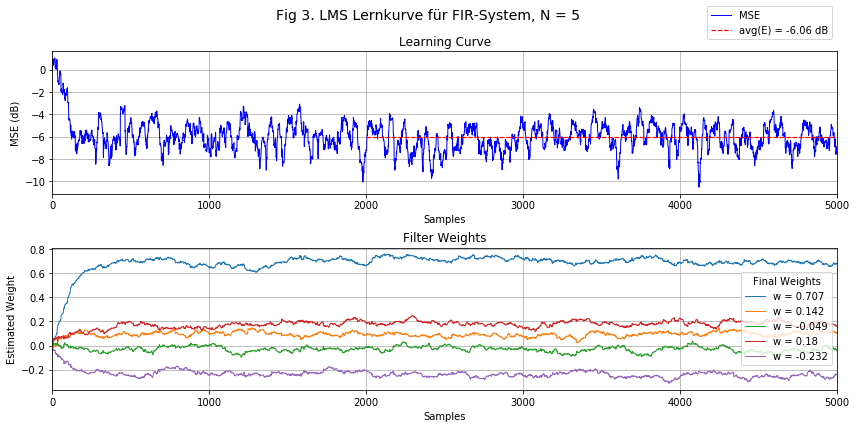

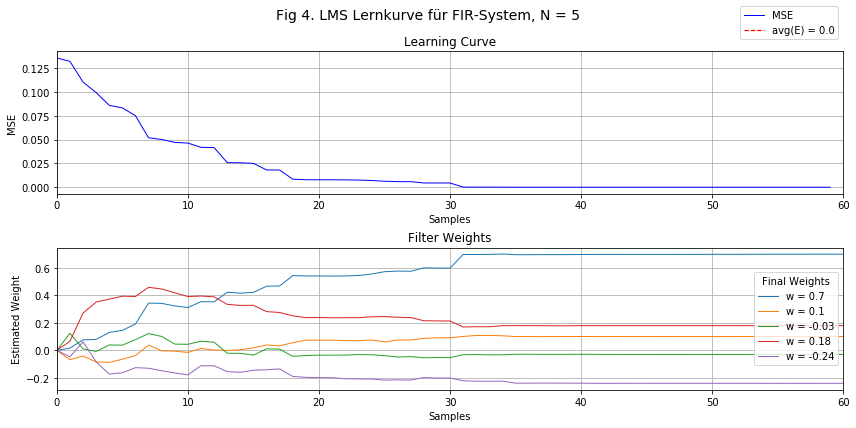

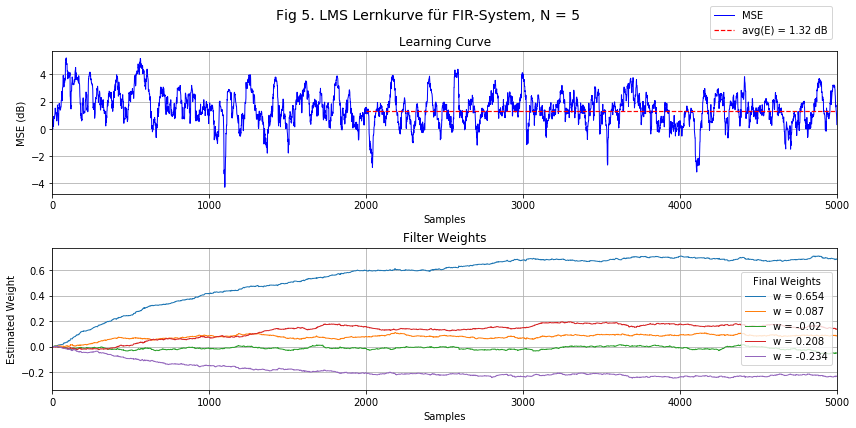

In [8]:
# N = 5
N, mu, var = 5, 0.01, 0.1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 3. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, mu, var = 5, 0.1, 0
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, 60, 'Fig 4. LMS Lernkurve für FIR-System, N = '+str(N), style='lin')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, mu, var = 5, 0.001, 1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 5. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 3.** Mit $N = 5$ erhält man die selbe Rauschunterdrückung von etwa $-7\,dB$ selbst bei einer weiteren Verzehnfachung der Rauschvarianz im Vergleich zu den Ausgangsbedingungen in *Fig 1* und *Fig 2*.

**Fig 4.** Exemplarisch wird hier eine sehr große Schrittweite von $\mu = 0.1$ *ohne* AWGNS gewählt um zu demonstrieren, dass der LMS Algorithmus unter Optimalbedingungen (kein Rauschen in der Übertragungsstrecke) sehr schnell die exakten, optimale Gewichtung mit $h_0 = 0.7, h_1 = 0.1, h_2 = -0.03, h_3 = 0.18, h_4 = -0.24$ adaptieren kann. Dies entspricht exakt den Werten des eigentlich unbekannten Systems (siehe oben).

**Fig 5.** Erhöht man die Varianz des Rauschens auf $\sigma^2 = 1$ so stellt sich trotz $N = 5$ und einer geringen Schrittweite keine sonderliche Fehlerminimierung jenseits von $-2\,dB$ ein. Eine Betrachtung von $\sigma^2 = 10$ ist an dieser Stelle also hinfällig.

## Aufgabe 1: FIR Systemidentifikation via RLS Algorithmus

* RLS: N = 1, w = [0.70026814]
       with AWGNS variance = 0.001, SNR = 27.84 dB


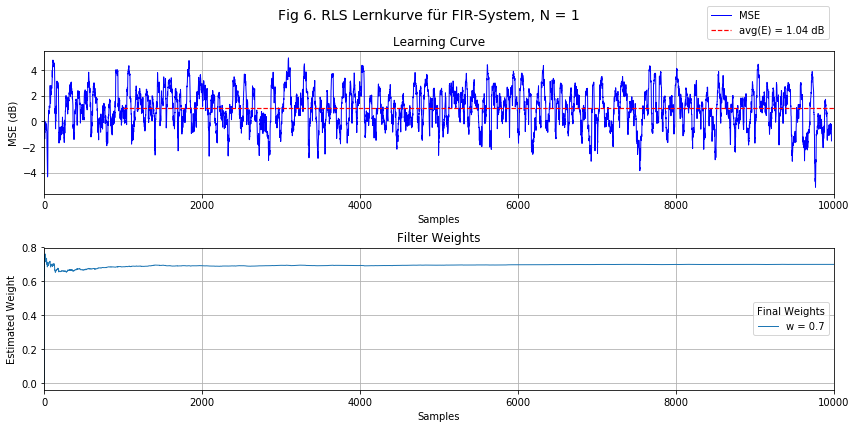

In [9]:
# FIR RLS study
# N  = 1, 2, 5
# var = 0.001, 0.1, 1, 10

# Style of displayed plot
plotLen = 10000

# N = 1
N, var = 1, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 6. RLS Lernkurve für FIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 6.** Analog zur Betrachtung des LMS Algorithmus wurde hier zunächst für $N = 1$ das AWGNS möglichst gering gehalten. Eine Verbesserung durch die Adaption des RLS ist hier nicht festzustellen, denn der Fehler bleibt auch über die gesamte Signallänge etwa gleich groß auch wenn sich die Adaption des Filterkoeffizienten zu $h_0 = 0.7$ vergleichsweise schnell einstellt und somit bis auf minimale Abweichungen auf den selben Wert konvergiert wie der LMS Algorithmus.

* RLS: N = 2, w = [0.69861364 0.10507543]
       with AWGNS variance = 0.001, SNR = 27.69 dB


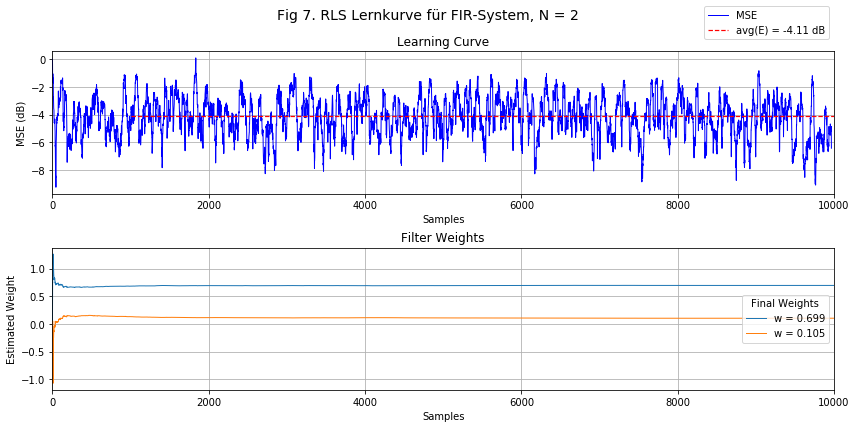

In [10]:
# Style of displayed plot
plotLen = 10000

# N = 2
N, var = 2, 0.001
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 7. RLS Lernkurve für FIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 7.** Mit der Erhöhung der Anzahl der Filterkoeffizienten auf $N = 2$ und gleichbleibender Varianz des AWGNS stellt sich eine durchschnittliche Fehlerminimierung von etwa $-4\,dB$ ein. Im Vergleich zum LMS konvergieren hierfür die Filterkoeffizienten deutlich schneller.

* RLS: N = 5, w = [ 0.70021833  0.09951102 -0.02867863  0.179025   -0.23760555]
       with AWGNS variance = 0.01, SNR = 17.86 dB
* RLS: N = 5, w = [ 0.70112843  0.10020714 -0.03240493  0.1814512  -0.24031305]
       with AWGNS variance = 0.1, SNR = 7.84 dB
* RLS: N = 5, w = [ 0.7264949   0.10226528 -0.03217657  0.19947122 -0.24000983]
       with AWGNS variance = 10, SNR = -12.16 dB


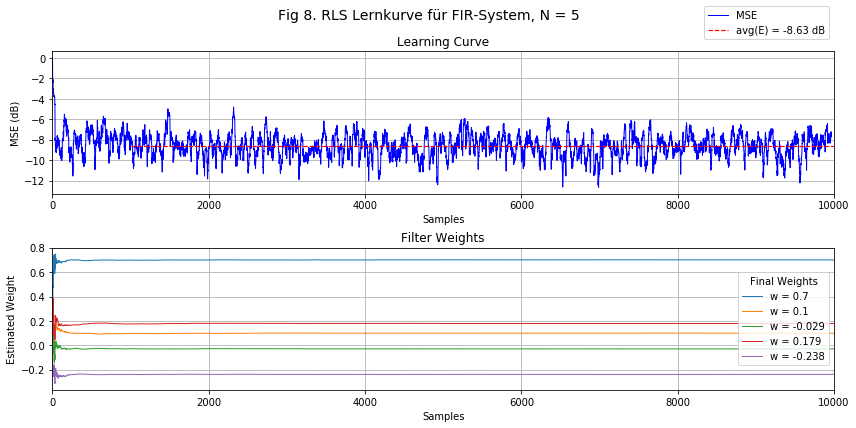

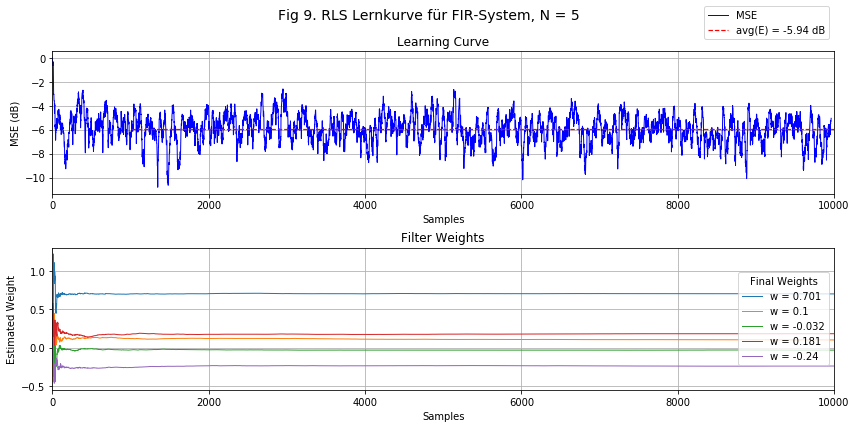

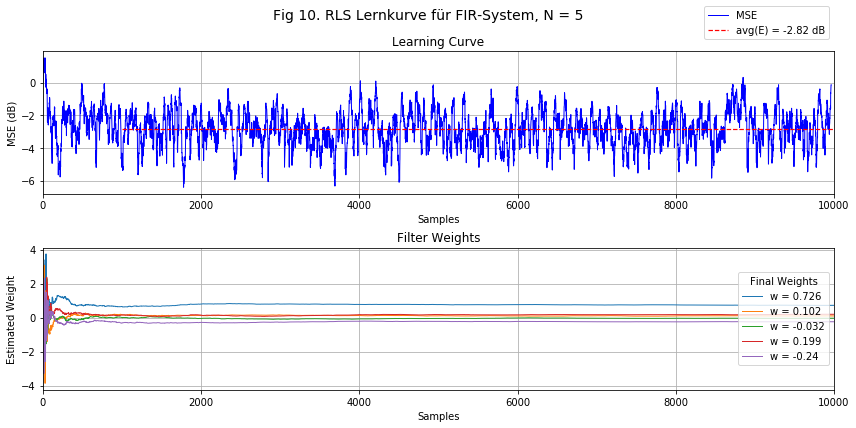

In [11]:
# Style of displayed plot
plotLen = 10000

# N = 5
N, var = 5, 0.01
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 8. RLS Lernkurve für FIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, var = 5, 0.1
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 9. RLS Lernkurve für FIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

N, var = 5, 10
HfirDn, SNRdB = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.rlsAlg(N, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 10. RLS Lernkurve für FIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 8.** Nach Erhöhung der Filterkoeffizienten auf $N = 5$ stellt sich bei einer Rauschvarianz von $\sigma^2 = 0.01$ eine Rauschunterdrückung von etwa $-11\,dB$ im Verhältnis zum ersten Fehler ein.

**Fig 9.** Auch nach Erhöhung der Rauschvarianz auf $\sigma^2 = 0.1$ ist noch eine durchschnittliche Rauschunterdrückung von etwa $-5\,dB$ zu verzeichnen. Dies ist ein vergleichbares Ergebniss mit dem LMS - doch stellt sich hier die Adaption deutlich schneller ein.

**Fig 10.** Selbst nach einer Erhöhung der Rauschvarianz auf $\sigma^2 = 10$ ist noch eine durchschnittliche Fehlerminimierung von etwa $-1\,dB$ bis $-5\,dB$ zu verzeichnen. Auch die Adaption stellt sich hier erstaunlich schnell ein im Vergelich zum Verlauf der Lernkurve des LMS.

## Aufgabe 2: IIR Systemidentifikation
Für das IIR-Filter: Stelle die gleichen Untersuchungen wie beim FIR-Filter an.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


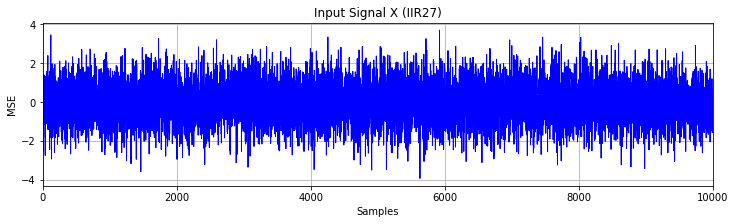

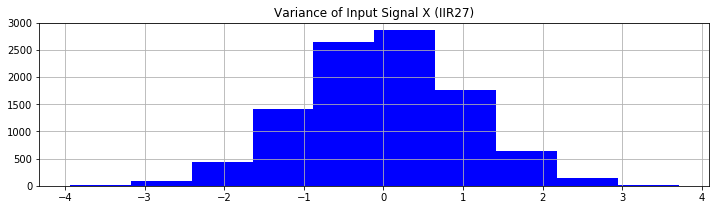

In [12]:
# load IIR data from dictionary
HiirD = importMat['System_IIR27']['D_']
HiirX = importMat['System_IIR27']['X']

# check input signal variance and plot
ts.plot(HiirX,'Input Signal X (IIR27)','lin',10000)
ts.hist(HiirX,'Variance of Input Signal X (IIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))
#print('Eigenvalue Spread of X:', ts.eigSpread(HiirX,1000))

* LMS: N = 1, mu = 0.001, w = [1.00017139]
       with AWGNS variance = 0.001, SNR = 30.08 dB
* RLS: N = 1, w = [1.00007646]
       with AWGNS variance = 0.001, SNR = 30.07 dB


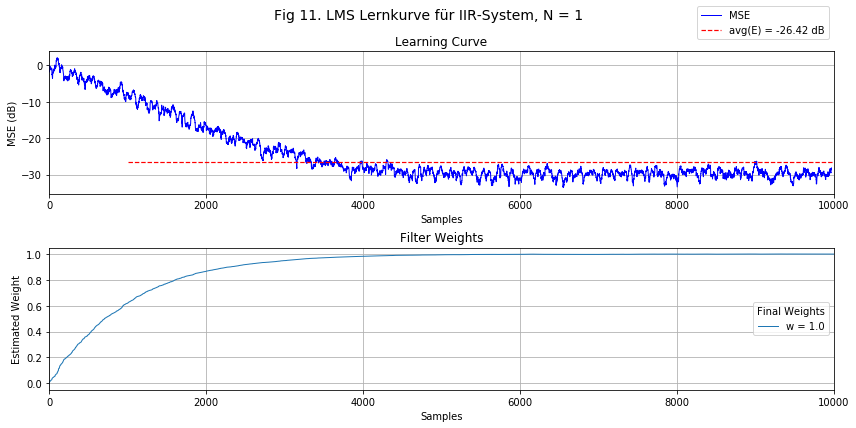

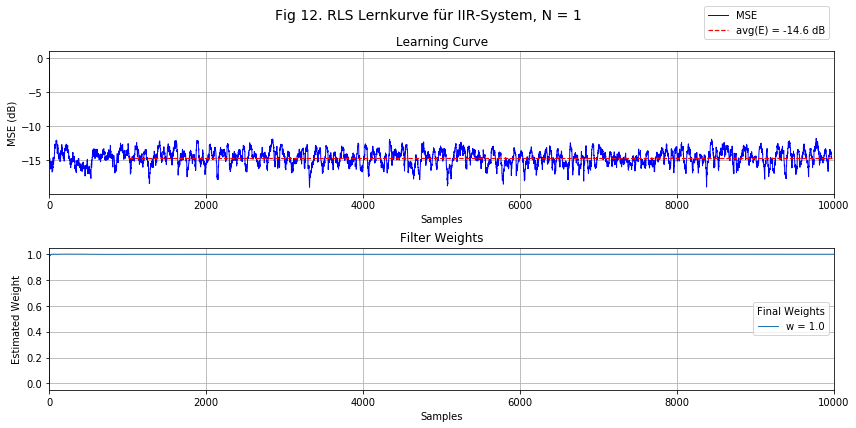

In [13]:
# IIR LMS/RLS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 1
N, mu, var = 1, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirX, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 11. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 1
N, var = 1, 0.001
HiirDn, SNRdB = ts.addNoise(HiirX, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 12. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=1000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 11 & 12.** Der LMS-Algorithmus erzielt anhand des IIR-Systems bei einer Rauschvarianz von $\sigma^2 = 0.001$ eine Fehlerminimierung von etwa $-3.8\,dB$. Der RLS-Algorithmus erzielt unter den selben Bedingungen durchschnittlich $-2\,dB$.


* LMS: N = 2, mu = 0.001, w = [0.99924452 0.83974889]
       with AWGNS variance = 0.001, SNR = 34.58 dB
* RLS: N = 2, w = [ 9.99885258e-01 -7.88799868e-04]
       with AWGNS variance = 0.001, SNR = 30.23 dB


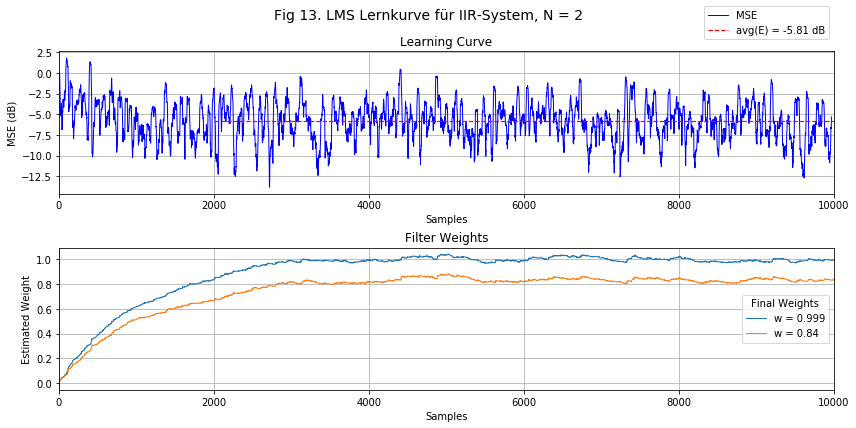

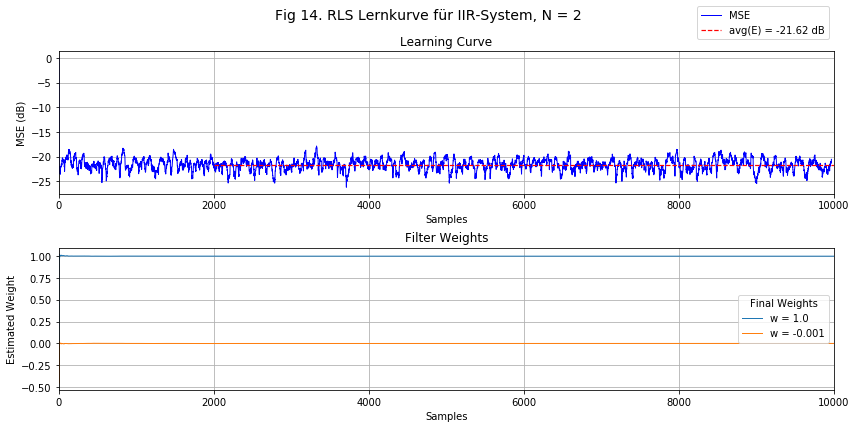

In [14]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.001, 0.001
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 13. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var = 2, 0.001
HiirDn, SNRdB = ts.addNoise(HiirX, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 14. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=2000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 13 & 14.** Bei Erhöhung der verfügbaren Filterkoeffizienten auf $N = 2$ bei gleichbleibender Rauschvarianz erzielt der LMS durchschnittlich eine Fehlerminimierung von etwa $-6\,dB$ und der RLS etwa $-3\,dB$. Zu beachten ist die stark unterschiedliche Konvergenzzeit der beiden Algorithmen.

* LMS: N = 5, mu = 0.001, w = [0.99069487 0.82047027 0.64104063 0.49225943 0.40131333]
       with AWGNS variance = 0.1, SNR = 14.51 dB
* RLS: N = 5, w = [1.00594318 0.82190793 0.63613005 0.49955186 0.393441  ]
       with AWGNS variance = 0.1, SNR = 14.53 dB


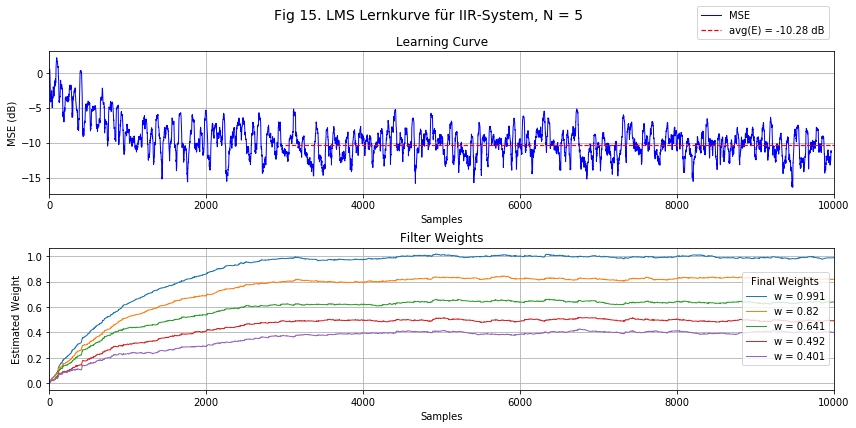

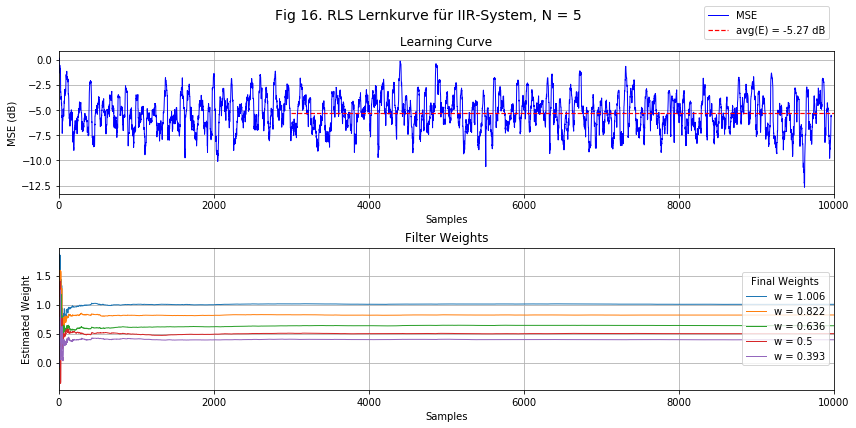

In [15]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 5
N, mu, var = 5, 0.001, 0.1
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 15. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=3000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var = 5, 0.1
HiirDn, SNRdB = ts.addNoise(HiirD, var)
E, W, w, Yd = algo.rlsAlg(N, HiirX, HiirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 16. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=3000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 15 & 16.** Nach Erhöhung der Filterkoeffizienten auf $N = 5$ und der Rauschvarianz des AWGNS auf $\sigma^2 = 0.1$ erzielt der LMS Algorithmus durchschnittlich etwa $-9\,dB$ und der RLS Algorithmus etwa $-7\,dB.$

#### Zu Aufgabe 1 & 2: Systemidentifikation eines FIR/IIR-Systems mit variablem AWGNS via LMS und RLS Algorithmus

Im Allgemeine unterscheiden sich der LMS- und der RLS-Algorithmus anhand ihrer Konvergenzzeit, der resultierenden Fehlerminimierung, dem Rechenaufwand und den Anwendungsfall.

Der Hauptunterschied liegt darin, dass der LMS Algorithmus ein Markov Prozess ist. Der LMS besitzt einen Momentanzustand, speichert aber keine vergangenen Daten im laufenden Vorgang des Adaptionsprozesses. Diese Eigenschaft ist gut für zeitlich veränderliche Signale geeignet, denn vergangene Information würde so zu fehlerhafter Information über die momentanen Werte führen. Diese Eigenschaft wird sich sicher in der folgenden Simulation des Systemwechsels (Aufgabe 3) zeigen. Im Austausch für dieses Verhalten pendeln sich die Werte des Filters trotz zu beobachtender Konvergenz nie ganz ein, sondern kreisen immer um das Optimum. In dieser Hinsicht ist der RLS "stabiler" in der Konvergenz der Filterkoeffizienten (Bemerkung: Mit "Stabilität" ist hier nicht das Verhalten des Filters gemeint, denn ein FIR-Filter ist immer stabil da er keinen rekursiven Anteil besitzt).

Der RLS-Algorithmus hingegen verwendet zur Optimierung außer den Momentanwerten auch alle vergangenen Informationen zur Optimierung der Adaption. Dies kann im Gegenteil zum LMS zu fehlerhaftem Verhalten bei zeitlich veränderlichen Signalen führen. Diese Schwachstelle kann vermindert werden indem ein sogenannter "Forgetting Factor" im RLS Algorithmus eingeführt wird, welcher vergangene Werte bis hin zum absoluten Vergessen weniger stark gewichtet.
Der RLS Algorithmus ist außerdem rechenintensiver gegenüber dem LMS Algorithmus. Im Austausch für diese Schwächen konvergiert der RLS Algorithmus deutlich schneller und bleibt bei einmaliger Konvergenz sehr stabil. Bei stochastisch stationären, zeitlich unveränderlichen Prozessen liefert der RLS-Algorithmus stabile Ergebnisse und ist bei außreichender verfügbarer Rechenleistung zu bevorzugen. Dies zeigt sich auch in der Verbesserung des Signal-Rausch-Verhältnis, denn der RLS führt im Schnitt bei der selben Rauschvarianz teilweise zu besseren Ergebnissen durch eine bessere Rauschunterdrückung.

Im Allgemeinen ist es bekannt das der RLS-Algorithmus besser für deterministische Prozesse geeignet ist und der LMS-Algorithmus für stochastische Prozesse. Da in dieser Simulation nur die Adaption für stochastische Prozesse analysiert wird ist auch nicht zu erwarten, dass der RLS-Algorithmus im Vergleich zum LMS gut abschneidet.

Zu beachten ist außerdem das die Fehlerminimierung durch den RLS-Algorithmus deutlich früher erfolgt als bei dem LMS-Algorithmus. Dies ist bspw. nicht berücksichtigit in der Bildung der durchschnittlichen Fehlerminimierung `avg(E)`. Diese wird immer zu gunsten des LMS-Algorithmus nach der optisch erreichten Konvergenz durch den Plot gebildet. Würde dieser Wert direkt nach der Konvergenz des RLS-Algorithmus erfolgen würde die durchschnittlche Fehlerminimierung für den LMS-Algorithmus deutlich schlechter ausfallen, da der LMS hier noch nicht nahe genug am Optimum liegt.


## Aufgabe 3
Es soll nun der Einfluss eines plötzlichen Systemwechsels untersucht werden. Dazu werden die Filterkoeffizienten des erzeugenden Systems nach 5000 Iterationen geändert. Lade nun die Datei Systemwechsel_FIR.mat und Systemwechsel_IIR.mat. Sie enthalten die gleichen Signale wie schon System_FIR.mat und System_IIR.mat. Zeige wiederum das Lernverhalten für verschiedene Störeinflüsse, Lernalgorithmen und Fitlerordungen. Erläutere auch hieran das Adaptionsverhalten. Welches Verfahren eignet sich unter welchen Bedingungen am besten?

Input signal 1 mean:  -0.010424975412711203
Input signal 1 variance:  0.5975436877185286
Input signal 2 mean:  -0.035691786431926054
Input signal 2 variance:  1.2498135548043237


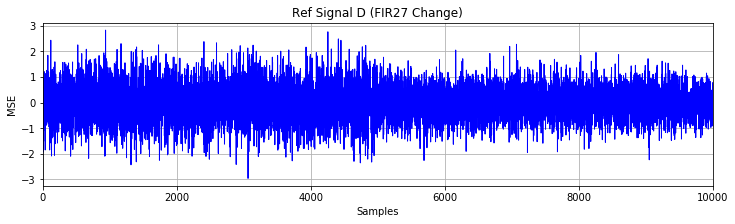

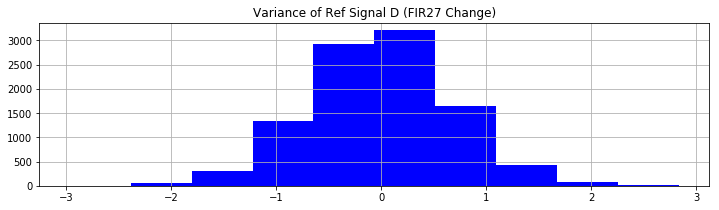

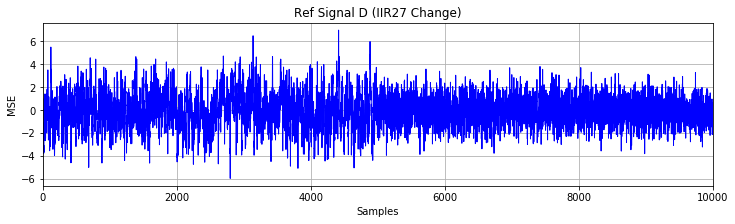

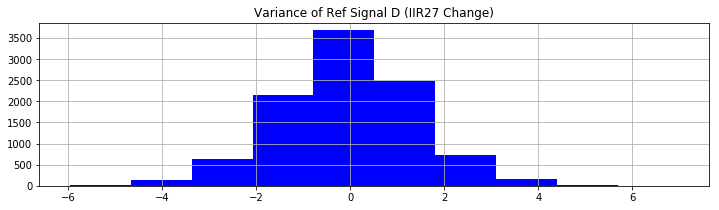

In [16]:
# load FIR data from dictionary
HfirDc = importMat['Systemwechsel_FIR27']['D_']
HfirXc = importMat['Systemwechsel_FIR27']['X']
HiirDc = importMat['Systemwechsel_IIR27']['D_']
HiirXc = importMat['Systemwechsel_IIR27']['X']

# check input signal 1 variance and plot
ts.plot(HfirDc,'Ref Signal D (FIR27 Change)','lin',10000)
ts.hist(HfirDc,'Variance of Ref Signal D (FIR27 Change)')
print('Input signal 1 mean: ',np.mean(HfirDc[0,0:5000]))
print('Input signal 1 variance: ',np.var(HfirDc[0,0:5000]))

# check input signal 2
ts.plot(HiirDc,'Ref Signal D (IIR27 Change)','lin',10000)
ts.hist(HiirDc,'Variance of Ref Signal D (IIR27 Change)')
print('Input signal 2 mean: ',np.mean(HiirDc[0,5000:]))
print('Input signal 2 variance: ',np.var(HiirDc[0,5000:]))

**Plots oben:** Klar in den Plots oben zu sehen ist der Systemwechsel bei der Hälfte (ab Sample 5000) des Signals.

* LMS: N = 5, mu = 0.01, w = [0.99095553 0.42059344 0.16770692 0.05931755 0.02989457]
       with AWGNS variance = 0.1, SNR = 13.11 dB
* RLS: N = 5, w = [1.00890608 0.60668462 0.38157426 0.2709589  0.20274539]
       with AWGNS variance = 0.1, SNR = 13.15 dB


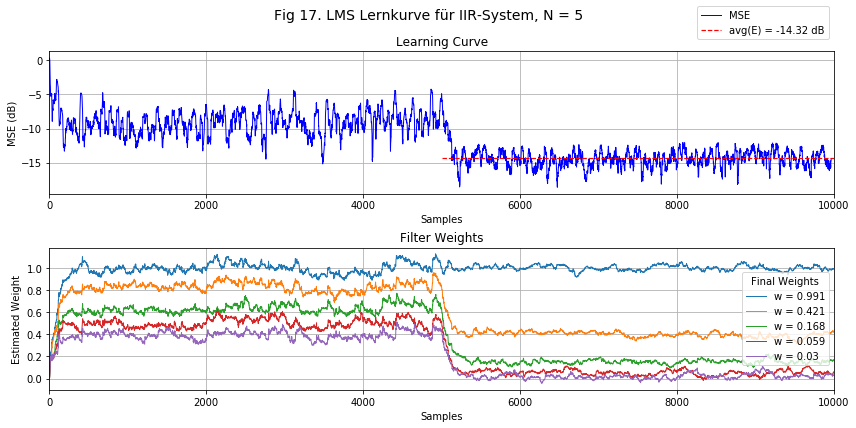

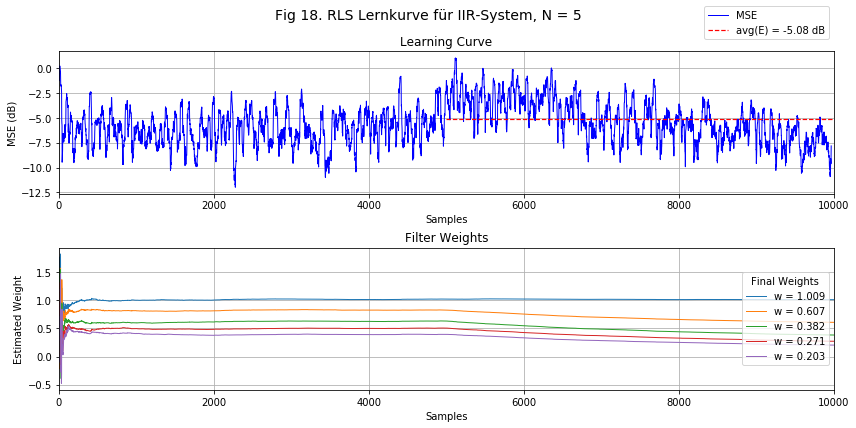

In [32]:
# IIR LMS/RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# LMS, N = 5
N, mu, var = 5, 0.01, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 17. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var = 5, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 18. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 17 & 18.**

* LMS: N = 2, mu = 0.01, w = [0.98111102 0.40876587]
       with AWGNS variance = 0.1, SNR = 13.21 dB
* RLS: N = 2, w = [1.0024786  0.62332184]
       with AWGNS variance = 0.1, SNR = 13.14 dB


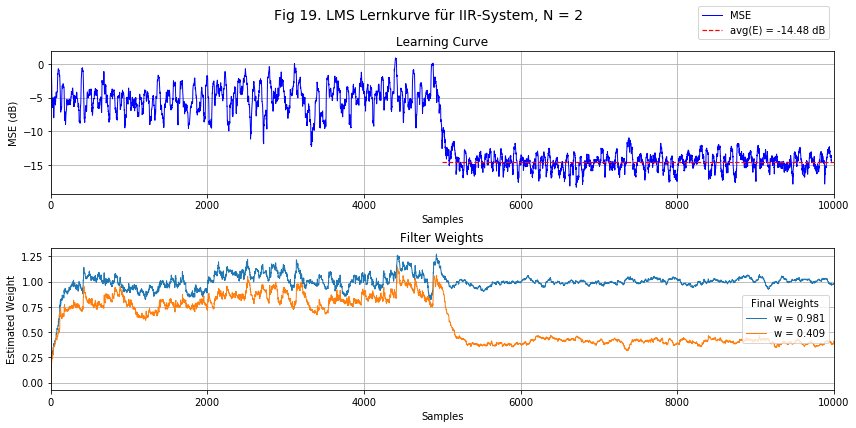

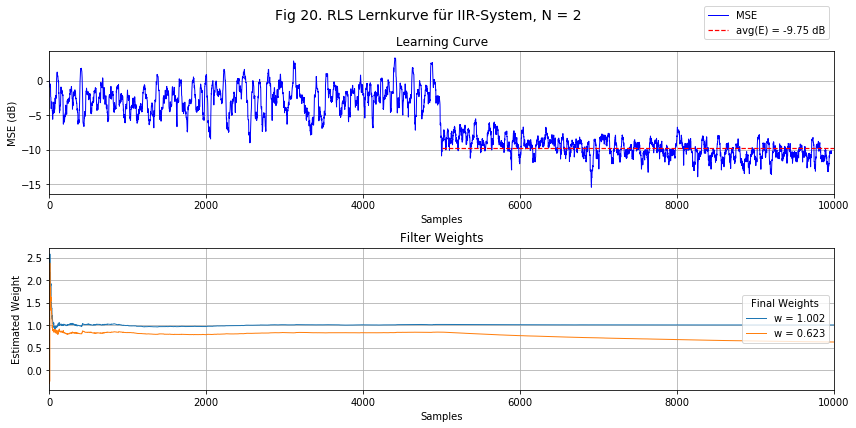

In [43]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 2
N, mu, var = 2, 0.01, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 19. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var = 2, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 20. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 19 & 20.**

* LMS: N = 1, mu = 0.01, w = [1.0319817]
       with AWGNS variance = 0.1, SNR = 13.12 dB
* RLS: N = 1, w = [1.0169446]
       with AWGNS variance = 0.1, SNR = 13.22 dB


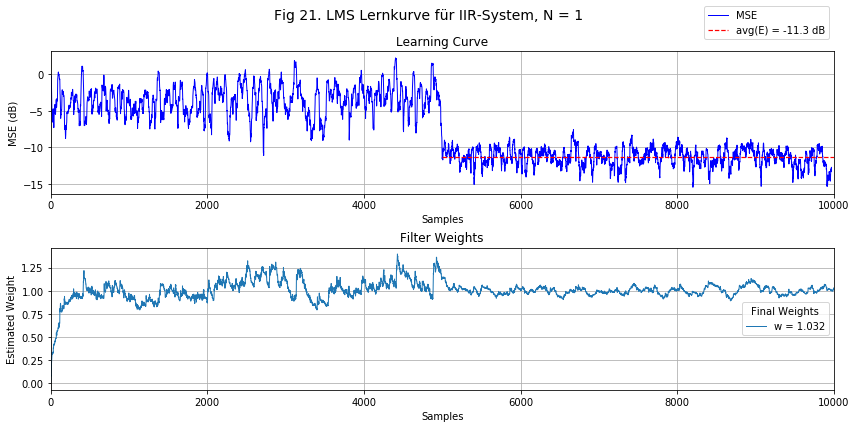

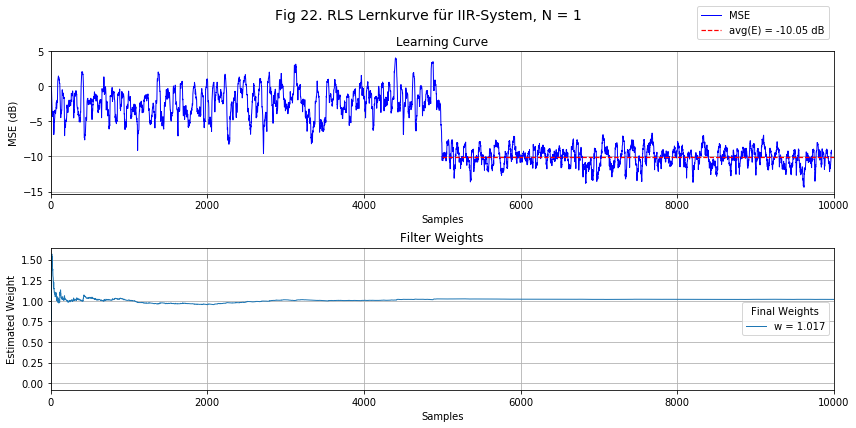

In [44]:
# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# LMS, N = 1
N, mu, var = 1, 0.01, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 21. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 1
N, var = 1, 0.1
HiirDcn, SNRdB = ts.addNoise(HiirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HiirXc, HiirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 22. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 21 & 22.**

* LMS: N = 5, mu = 0.01, w = [ 0.34815633 -0.05947255  0.27546396 -0.18982444 -0.19655367]
       with AWGNS variance = 0.1, SNR = 6.73 dB
* RLS: N = 5, w = [ 0.54671788  0.04518018  0.13968591  0.00433292 -0.2220918 ]
       with AWGNS variance = 0.1, SNR = 6.73 dB


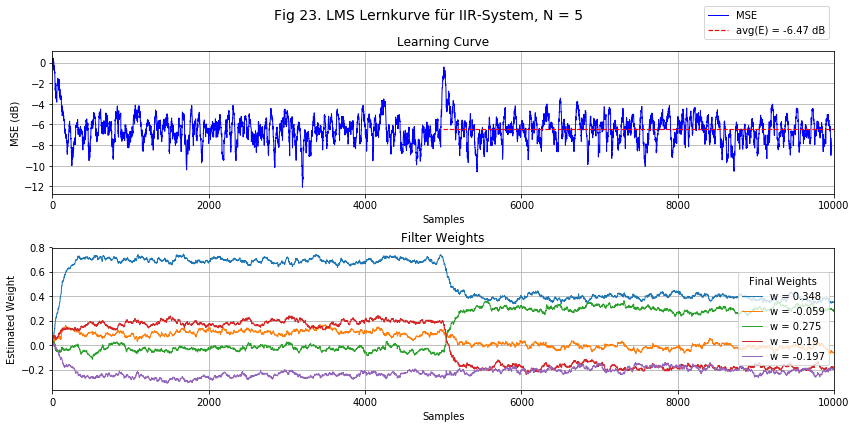

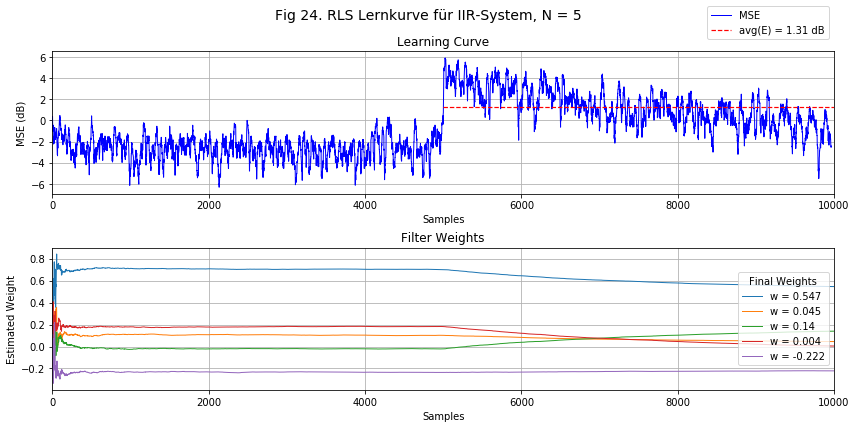

In [46]:
# FIR LMS/RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# LMS, N = 5
N, mu, var = 5, 0.01, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 23. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 5
N, var = 5, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 24. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 23 & 24.**

* LMS: N = 2, mu = 0.01, w = [0.38720384 0.01408189]
       with AWGNS variance = 0.1, SNR = 6.72 dB
* RLS: N = 2, w = [0.5502285  0.04987881]
       with AWGNS variance = 0.1, SNR = 6.55 dB


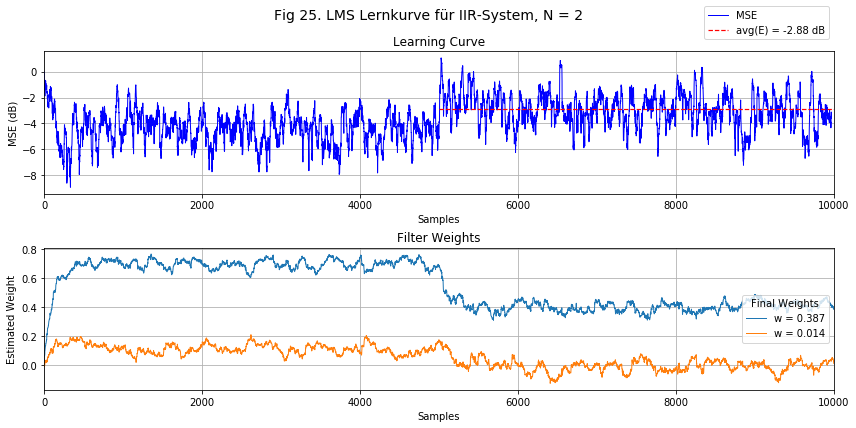

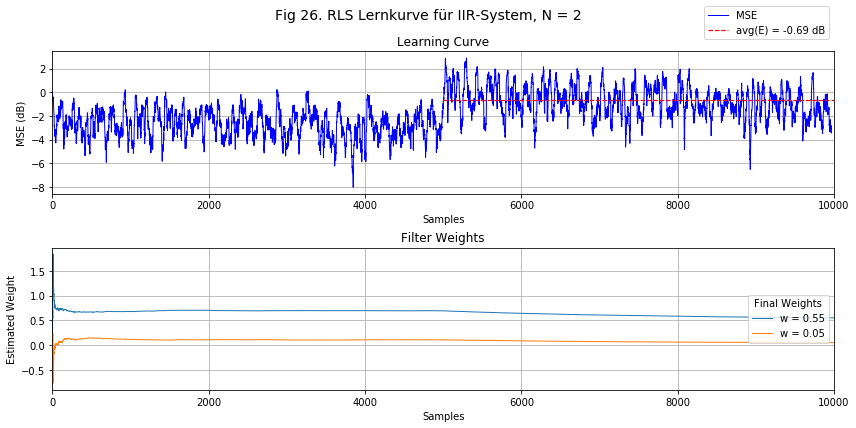

In [47]:
# LMS, N = 2
N, mu, var = 2, 0.01, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 25. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 2
N, var = 2, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 26. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 25 & 26.**

* LMS: N = 1, mu = 0.01, w = [0.38018661]
       with AWGNS variance = 0.1, SNR = 6.71 dB
* RLS: N = 1, w = [0.54972629]
       with AWGNS variance = 0.1, SNR = 6.74 dB


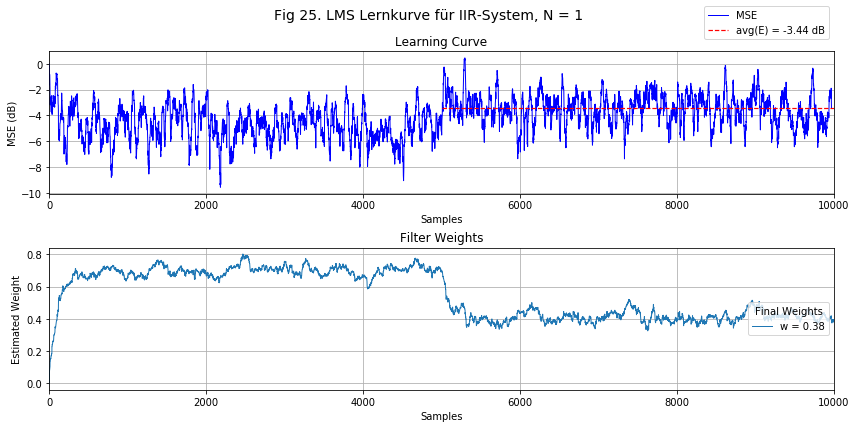

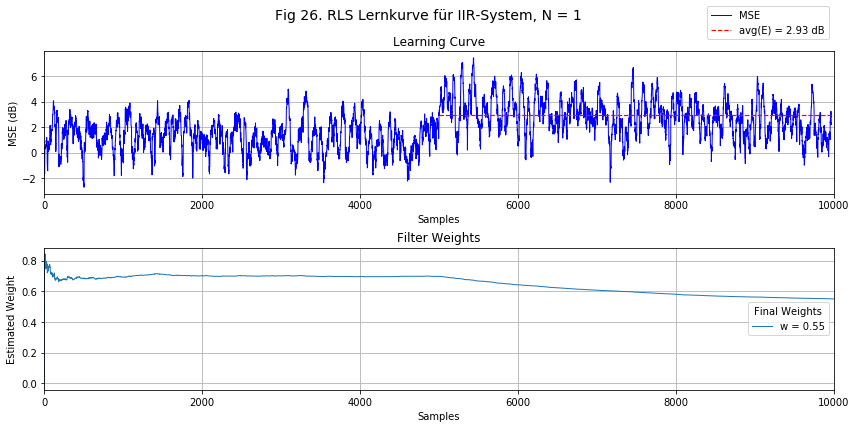

In [49]:
# LMS, N = 1
N, mu, var = 1, 0.01, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 25. LMS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

# RLS, N = 1
N, var = 1, 0.1
HfirDcn, SNRdB = ts.addNoise(HfirDc, var)
E, W, w, Yd = algo.rlsAlg(N, HfirXc, HfirDcn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 26. RLS Lernkurve für IIR-System, N = '+str(N), style='log',avgFrom=5000)
print('       with AWGNS variance = '+str(var)+', SNR = '+str(SNRdB)+' dB')

**Fig 25 & 26.**

#### Zu Aufgabe  3: Systemwechsel

Im Allgemeine unterscheiden sich der LMS- und der RLS-Algorithmus anhand ihrer Konvergenzzeit, der resultierenden Fehlerminimierung, dem Rechenaufwand und den Anwendungsfall.

## Aufgabe 4
Es soll nun ein Kernel Least Mean Squares (KLMS) Filter entworfen werden, dass eine Zeitreihenschätzung vornimmt. Zum Training wird eine Zeitreihe mit 500 Werten in der Datei Training.mat gegeben. Das trainierte Filter soll anschließend mit der Zeitreihe in Test.mat getestet werden. Der Kernel des KLMS darf aus der Familie der Exponentialfunktionen frei gewählt werden (Gauss, Laplace, o.ä.). Zum Vergleich der Schätzfähigkeit des KLMS sollen sowohl 5 vergangene als auch 10 vergangene Werte zur Schätzung herangezogen werden. Das gleiche Testszenario soll weiterhin mit einem LMS umgesetzt und für einen Vergleich zum KLMs herangezogen werden. Dazu sind Fehlerkurven auf den Testdaten zu erstellen sowie Erläuterungen zu den Einflüssen der jeweiligen Parameter der Filter anzugeben.

In [26]:
# load KLMS training and test data from dictionary
x_training = importMat['Training']['x_training']
x_test = importMat['Test']['x_test']

### Literaturverzeichnis
[1] Moschytz, G., & Hofbauer, M. (2000). Adaptive Filter. Berlin ua: Springer.

[2] Liu, W., Principe, J. C., & Haykin, S. (2011). Kernel adaptive filtering: a comprehensive introduction (Vol. 57). John Wiley & Sons.